# FUNCTIONS

In [ ]:
# !git clone https://github.com/Line233/one.git ./one
# !mv ./one/tool.py ./

In [ ]:
import torch
import random
import torchvision
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import torch.utils.data as data
import torch.nn as nn
import tool
%matplotlib inline
import importlib
importlib.reload(tool)

In [ ]:
class mnist_data(data.Dataset):
    def __init__(self,x,y):
        self.x=x.float()
        self.y=y.long()
    def __len__(self):
        return len(self.x)
    def __getitem__(self,index):
        if self.y is not None:
            return self.x[index].reshape([-1]),self.y[index].long()
        else:
            return self.x[index].reshape([-1])

In [ ]:
class mnist_single(nn.Module):
    def __init__(self,input_a,hidden_a,device=torch.device('cpu'),rand_seed=10):
        super(mnist_single,self).__init__()
        torch.manual_seed(rand_seed)
        self.device=device
        self.hidden_a=hidden_a
        self.linear1=nn.Linear(input_a,self.hidden_a)
        self.relu=nn.ReLU()
        self.linear2=nn.Linear(self.hidden_a,10)
        self.softmax=nn.Softmax(dim=1)
        self.lossF=nn.CrossEntropyLoss()
    def forward(self,input):
        input=input.to(self.device)
        res=self.linear1(input)
        res=self.relu(res)
        res=self.linear2(res)
        res=self.softmax(res)
        return res

    def expand(self):
        new_linear=nn.Linear(self.linear1.in_features,self.linear1.out_features+1)
        new_linear2=nn.Linear(self.linear2.in_features+1,self.linear2.out_features)
        with torch.no_grad():
            # weight=np.zeros([self.linear1.out_features])
            # for i in range(self.linear1.out_features):
            #     weight[i]=abs(self.linear1.weight.data[i]*self.linear2.weight.data[:,i])
            index=0

            weight=self.__expand_weight_down__(self.linear1.weight.data.detach(),index)
            bias=self.__expand_weight_down__(self.linear1.bias.data.detach(),index)
            new_linear.weight.data=weight
            new_linear.bias.data=bias

            weight2=self.__expand_weight_up__(self.linear2.weight.data.detach(),index)
            new_linear2.weight.data=weight2

        self.linear1=new_linear
        self.linear2=new_linear2 
        return

    def __expand_weight_up__(self,weight,index):
        with torch.no_grad():
            shape=torch.tensor(weight.shape)
            shape[1]=1
            # new_weight=weight.data[:,index].reshape(shape.tolist()).clone()*0.4
            new_weight=torch.zeros(shape.tolist())+0.001
            weight.data[:,index]*=1
            new_weight=torch.cat([weight,new_weight],dim=1)
        return new_weight

    def __expand_weight_down__(self,weight,index):
        with torch.no_grad():
            shape=torch.tensor(weight.shape)
            shape[0]=1
            # new_weight=weight[index].reshape(shape.tolist()).clone()*0.4
            new_weight=torch.zeros(shape.tolist())+0.001
            weight.data[index]*=1
            new_weight=torch.cat([weight,new_weight])
        return new_weight
    
    def reset_loss_record(self):
        self.__total_loss__=0.0
        self.__right_num__=0
        self.__total_num__=0
    def computeloss(self,x,y,res):
        y=y.to(self.device)
        loss=self.lossF(res,y)
        self.__total_loss__+=loss.tolist()*len(x)
        a=res.argmax(dim=1)
        self.__right_num__+=torch.eq(a,y).sum().tolist()
        self.__total_num__+=len(x)
        return loss
    def get_loss(self):
        return self.__total_loss__/self.__total_num__,self.__right_num__/self.__total_num__

In [ ]:
class mnist_cov(nn.Module):
    def __init__(self,input_a,input_channel,device=torch.device('cpu'),rand_seed=10):
        super(mnist_cov,self).__init__()
        torch.manual_seed(rand_seed)
        self.device=device
        self.inputa=input_a
        self.input_channel=input_channel

        self.out=nn.Sequential(
            nn.Conv2d(1,4,3,1,1),
            nn.MaxPool2d(3,2),
            nn.Conv2d(4,16,3,1,1),
            nn.MaxPool2d(3,2)
        )
        self.out2=nn.Sequential(
            nn.Linear(16,10),
            nn.Softmax(dim=1)
        )
        self.lossF=nn.CrossEntropyLoss()
        pass
    def forward(self,input):
        input=input.reshape([-1,self.input_channel,self.inputa,self.inputa]).to(self.device)
        res=self.out(input)
        res= res.reshape([-1,16])
        res=self.out2(res)
        return res
    def reset_loss_record(self):
        self.__total_loss__=0.0
        self.__right_num__=0
        self.__total_num__=0
    def computeloss(self,x,y,res):
        y=y.to(self.device)
        loss=self.lossF(res,y)
        self.__total_loss__+=loss.tolist()*len(x)
        a=res.argmax(dim=1)
        self.__right_num__+=torch.eq(a,y).sum().tolist()
        self.__total_num__+=len(x)
        return loss
    def get_loss(self):
        return self.__total_loss__/self.__total_num__,self.__right_num__/self.__total_num__

In [ ]:
def early_end(records,last,mini=1000,step=200,bias=0):
    if len(records)-last<mini:
        return False
    elif records[-step][2]-records[-1][2]-bias>0:
        return False
    else:return True
def dlr1(index):
    # return max(pow(0.1,index+3),pow(0.1,5))
    return 0.001

# DATA

In [ ]:
train_data=torch.load('./data/train_hidden')
valid_data=torch.load('./data/valid_hidden')
test_data=torch.load('./data/test_hidden')

In [ ]:
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
labels=['train_loss','train_precise','valid_loss','valid_precise']
select_loss=[True,False,True,False]
select_precise=[False,True,False,True]

In [ ]:
simple_data=mnist_data(valid_data[0:100][0].reshape([-1,10,10]),valid_data[0:100][1])

# TRAIN_CONV

In [ ]:
model=mnist_cov(10,1,device).to(device)
record1=[]

In [ ]:
record1+=tool.TrainTool.train_epoch(model,simple_data,valid_data,lr=0.0001,batch_size=1000,epoch=10)

In [ ]:
lc1=tool.learning_curve(record1,reshape=True)
lc1.save('./data/conv_lc.npy')

# TRAIN_SINGLE

In [ ]:
model_single=mnist_single(100,50,device=device).to(device)
res=[]
optim=torch.optim.Adam(model_single.parameters(),lr=0.001)

In [ ]:
res+=tool.TrainTool.train_epoch(model_single,train_data,valid_data,lr=0.001,batch_size=800,epoch=1,optim=optim)

In [ ]:
lc2=tool.learning_curve(res,labels,reshape=True)

In [ ]:
lc2=tool.learning_curve.load('./data/single_lc.npy',labels)

In [ ]:
lc2=tool.learning_curve.load(single_lc_name)

In [ ]:
lc2.draw(select=select_loss)
lc2.draw_range(select=select_loss,block_num=10,expand=20)

save

In [ ]:
single_lc_name='./data/single_lc.npy'
single_model_name='./data/single_model.npy'
single_optim_name='./data/single_optim'

In [ ]:
# lc2.save(single_lc_name)
# torch.save(model_single,single_model_name)
# torch.save(optim.state_dict(),single_optim_name)

In [ ]:
# tool.download('./data/single_lc.npy')
# tool.download('./data/single_model')

# ADAM_RESET

In [ ]:
ar_model=mnist_single(100,50,device)
ar_record=[]
ar_reset=[]

In [ ]:
current=tool.TrainTool.train_adam_reset(ar_model,simple_data,valid_data,dlr=dlr1,batch_size=1000,epoch=100,epoch_per=10,early_end=early_end)
ar_record.append(current[0])
ar_reset+=current[1]

In [ ]:
ar_lc=tool.learning_curve(ar_record,reshape=True)
ar_lc_reset=tool.learning_curve([ar_reset])

In [ ]:
# ar_lc.save('./data/ar_lc.npy')
# ar_lc_reset.save('./data/ar_lc_reset.npy')
# torch.save(ar_model,'ar_model')
# tool.download('./data/ar_lc.npy')
# tool.download('./data/ar_lc_reset.npy')
# tool.download('./data/ar_model')

# EXPAND

In [ ]:
ex_model=mnist_single(100,40,device)
ex_record=[]
ex_ex=[]

In [ ]:
current=tool.TrainTool.train_expand(ex_model,train_data,valid_data,dlr=dlr1,batch_size=1000,epoch=10000,epoch_per=1,early_end=early_end)
ex_record.append(current[0])
ex_ex+=current[1]

In [ ]:
ex_lc=tool.learning_curve(ex_record)
ex_lc.add_vlines(ex_ex)

In [ ]:
ex_lc.draw_range(block_num=10,select=select_precise)

In [ ]:
ex_lc.save('./data/ex_lc.npy')
torch.save(ex_model,'./data/ex_model')
# tool.downloads([
#     './data/ex_lc.npy',
#     './data/ex_model'
# ])

In [23]:
ex_lc=tool.learning_curve.load2('./data/ex_lc.npy',labels)
ex_lc.labels=labels

0


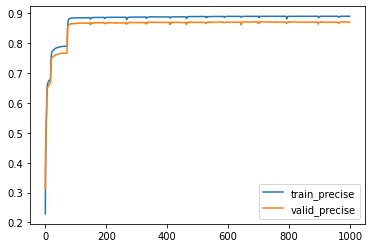

1


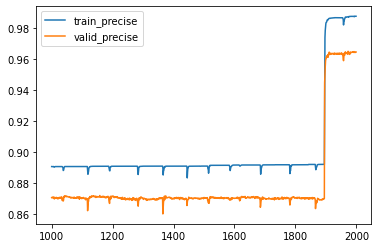

2


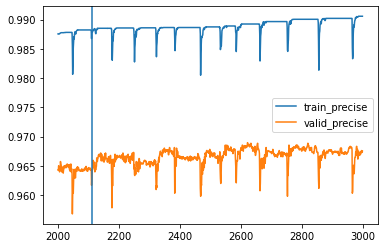

3


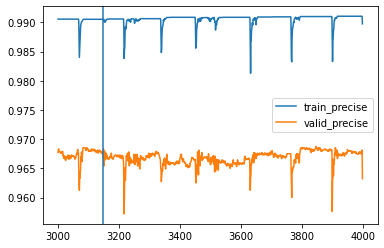

4


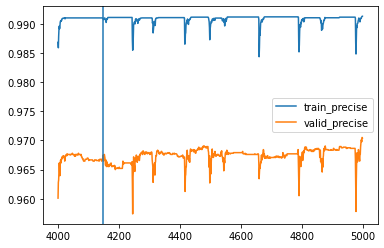

5


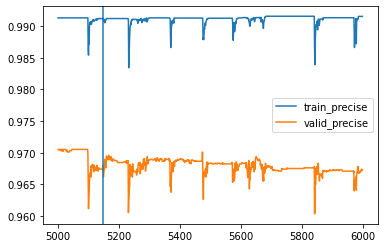

6


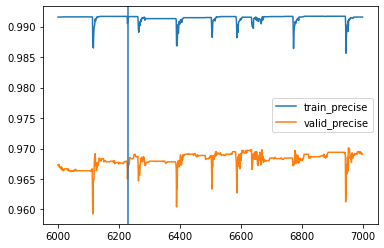

7


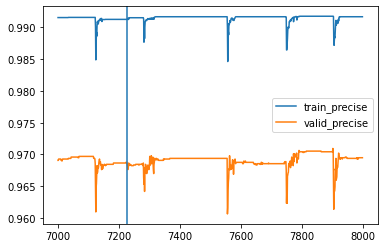

8


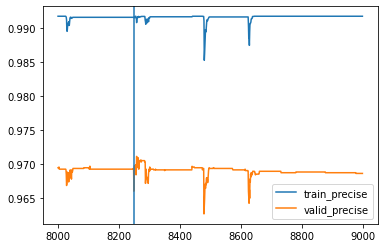

9


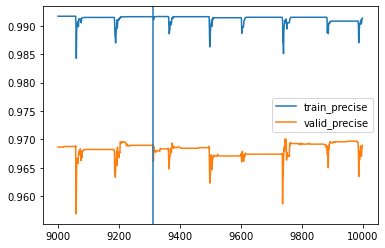

[<Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>]

In [24]:
ex_lc.draw_range(block_num=10,select=select_precise)

In [22]:
ex_lc.save('./data/ex_lc.npy')